In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

import numpy as np

In [32]:
def build_lenet5():
     ##LeNet requires to have input 32x32 based on its architecture
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1))) # first layer of network, that contains 6 filters with 5x5 with activation function ReLU - which introduces non-linearity to the model helping it to learn more complex patterns in the data
    model.add(layers.AveragePooling2D(pool_size=(2,2))) # pooling layer to reduce the dimension - it should make the position of object in the picture less relevant
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.Flatten()) # transforms 2D matrix into 1D vector to connect convolutional layers with dense layers
    model.add(layers.Dense(120, activation='relu')) # 120 neurons 
    model.add(layers.Dense(84, activation='relu')) # 84 neurons
    model.add(layers.Dense(10, activation='softmax')) # softmax outputs the probabilities for each class
    return model

In [33]:
lenet5_model = build_lenet5()
lenet5_model.summary()

/home/luky/playground/handwriting_recognition/lenet5/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)


(60000, 28, 28)


In [68]:

train_images = tf.pad(train_images, [[0, 0], [2, 2], [2, 2]])
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.pad(test_images, [[0, 0], [2, 2], [2, 2]])
test_images = tf.cast(test_images, tf.float32) / 255.0

train_images = 1.0 - train_images # to revert colors to train the network 

train_images_numpy = train_images.numpy()

def rotate_images(train_images_numpy) -> np.ndarray:
    for i in range(len(train_images_numpy)):
        if i % 2 ==0:
            k = np.random.choice([1, 2, 3])
            train_images_numpy[i] = np.rot90(train_images_numpy[i], k=k)
    return tf.convert_to_tensor(train_images_numpy)


In [71]:
def move_image(train_images_numpy) -> np.ndarray:
    for m in range(len(train_images_numpy)):
        if m % 3 ==0:
            no_of_columns_to_be_moved = 0
            no_size = 0
            for k in range(len(train_images_numpy[m])):
                if min(train_images_numpy[m,:,k]) != 1:
                    no_size+=1
                if no_size !=0:
                    break
            for i in range(len(train_images_numpy[m])):
                if min(train_images_numpy[m,:,i]) == 1: #no part of number is in this column
                    no_of_columns_to_be_moved+=1
                else:
                    train_images_numpy[m,:,i-no_of_columns_to_be_moved] = train_images_numpy[m,:,i]
            for j in range(no_of_columns_to_be_moved+no_size+1,len(train_images_numpy[m])):
                train_images_numpy[m,:,j] = 1
    return tf.convert_to_tensor(train_images_numpy) 



In [ ]:
train_images_numpy = train_images.numpy()
train_images = move_image(train_images_numpy)
train_images_numpy = train_images.numpy()
train_images = rotate_images(train_images_numpy)

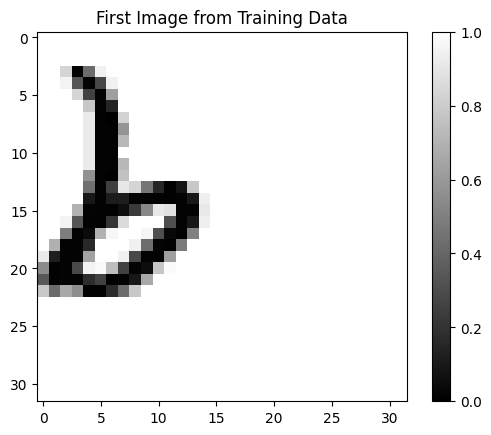

In [76]:
plt.imshow(train_images[4, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()

In [13]:
#from preprocess_png_images import Preprocessor
#preprocessor = Preprocessor(dataset_path = "data/kaggle_dataset/dataset")
#(train_images,train_labels) = preprocessor.preprocess_images()

In [14]:
#print(train_images.shape)
#preprocessor.plot_random_preprocessed_image()

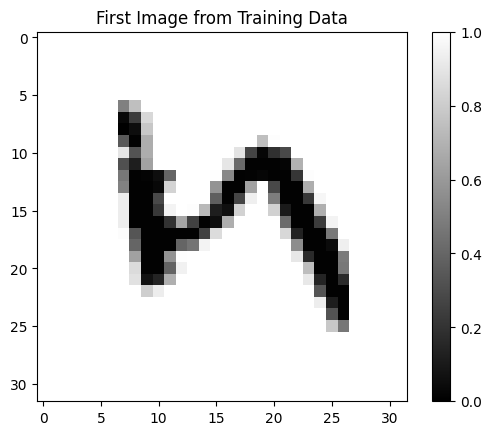

In [37]:

# Plotting the image
plt.imshow(train_images[0, :, :], cmap='gray')  # 'cmap' specifies that we want to see the image in grayscale
plt.title('First Image from Training Data')
plt.colorbar()
plt.show()


In [77]:


train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


#create batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)  # Shuffle and batch the data
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)  # Only batch the test data (no need to shuffle)
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>


In [78]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [79]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [80]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = lenet5_model(images,training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, lenet5_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lenet5_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [81]:
epochs = 4

for epoch in range(epochs):
    train_loss.reset_state()
    train_accuracy.reset_state()

    for images, labels in train_dataset:
        train_step(images, labels)
        
    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}')

KeyboardInterrupt: 

In [21]:
lenet5_model.save("lenet5_model.keras")